In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
%matplotlib inline
import os
from tensorflow.contrib.timeseries.python.timeseries import NumpyReader

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing   
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.layers import LSTM


Using TensorFlow backend.


In [2]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    dataset=dataset.tolist()
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

def split_dataset(data):
	predict_index=1      # the test data need to be two years!!!   
	# split into standard weeks
	train, test = data[0:len(data)-12*predict_index], data[len(data)-12*predict_index::]
	# restructure into windows of montyly data
	train = np.array(np.split(train, len(train)/12))
	test = np.array(np.split(test, len(test)/12))
	return train, test

In [3]:
def to_supervised(train, n_input, n_out):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return np.array(X), np.array(y)

In [4]:
def build_model(train_x,train_y,n_input,n_out,  n_steps, n_length):
	# define parameters
	verbose, epochs, batch_size = 2,200,32
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_x = train_x.reshape((train_x.shape[0], n_steps,1, n_length, n_features))
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1],1))
	# define model

	model = Sequential()
	model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(Dropout(0.5))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(Dropout(0.5))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(Dropout(0.5))
	model.add(TimeDistributed(Dense(100, activation='linear')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# fit network
	return model


In [5]:
# make a forecast
def forecast(model, history, n_input, n_steps, n_length):
	# flatten data
	data = np.array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	print (data.shape)
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, n_steps,1,n_length, 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)

	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input,n_steps, n_length):
	# fit model
#	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	print (len(history))
	print (history[0])
	#print (len(test))
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input,n_steps, n_length)
		print ("the prediction values are:{0}".format(yhat_sequence))
		print ("the real values are:{0}".format(test[i, :, 0]))
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = np.array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions) 
	return score, scores,predictions

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		print (actual.shape[1])
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		print (actual[:, i])
		print (predicted[:, i])
		print (mse)
		# calculate rmse
		rmse = np.sqrt(mse)
		# store
		scores.append(rmse)
    
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs

In [6]:
real_in_one=[]
prediction_in_one=[]
train_prediciton_in_one=[]
dataset_in_one=[]
signals=[]
all_signals=[]
file_name="ONI"
with open("{0}.txt".format(file_name)) as file:
    for lines in  file:
        every_signal=[]
        line=lines.split(",")
        for element in line:
            every_signal.append(float(element))
        all_signals.append(every_signal)
        signals.append(every_signal)

data={}
pd_date=pd.date_range('1/1/1950','12/1/2018',freq='MS')
data["date"]=pd_date

for i in range(len(signals)):
    index="f"+str(i)
    data[index]=signals[i]


df=pd.DataFrame(data)
df.to_csv("{0}_data.txt".format(file_name))

print (df.shape)

if(os.path.exists('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD')==False):
    os.makedirs('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD')

(828, 10)


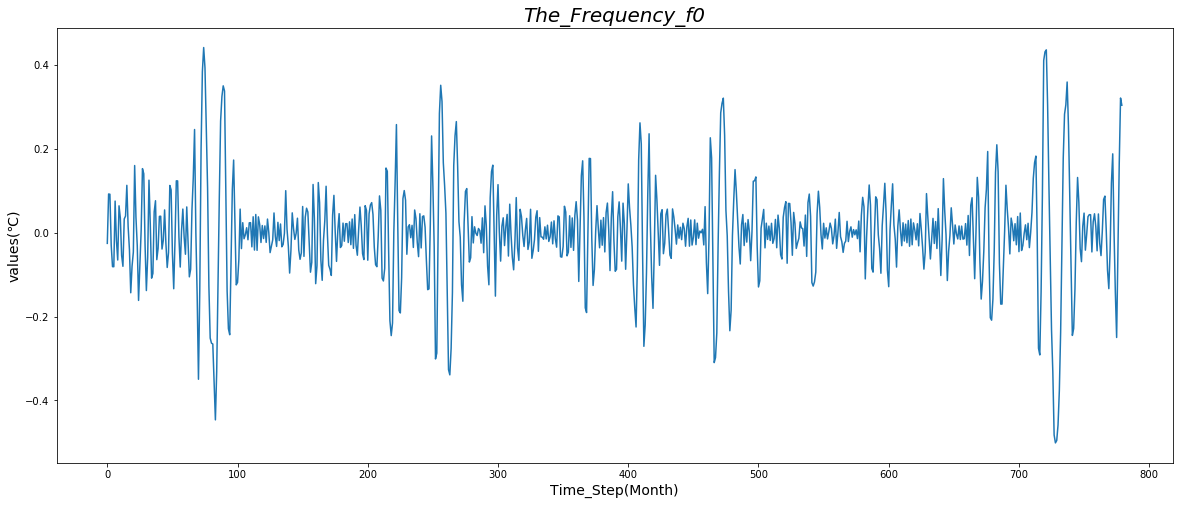

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 4s - loss: 0.0139
Epoch 2/200
 - 2s - loss: 0.0138
Epoch 3/200
 - 2s - loss: 0.0138
Epoch 4/200
 - 2s - loss: 0.0137
Epoch 5/200
 - 2s - loss: 0.0137
Epoch 6/200
 - 2s - loss: 0.0135
Epoch 7/200
 - 2s - loss: 0.0136
Epoch 8/200
 - 2s - loss: 0.0132
Epoch 9/200
 - 2s - loss: 0.0132
Epoch 10/200
 - 2s - loss: 0.0128
Epoch 11/200
 - 2s - loss: 0.0126
Epoch 12/200
 - 2s - loss: 0.0126
Epoch 13/200
 - 2s - loss: 0.0120
Epoch 14/200
 - 2s - loss: 0.0123
Epoch 15/200
 - 2s - loss: 0.0116
Epoch 16/200
 - 2s - loss: 0.0114
Epoch 17/200
 - 2s - loss: 0.0115
Epoch 18/200
 - 2s - loss: 0.0113
Epoch 19/200
 - 2s - loss: 0.0113
Epoch 20/200
 - 2s - loss: 0.0113
Epoch 21/200
 - 2s - loss: 0.0111
Epoch 22/200
 - 2s - loss: 0.0110
Epoch 23/200
 - 2s - loss:

(62, 12)


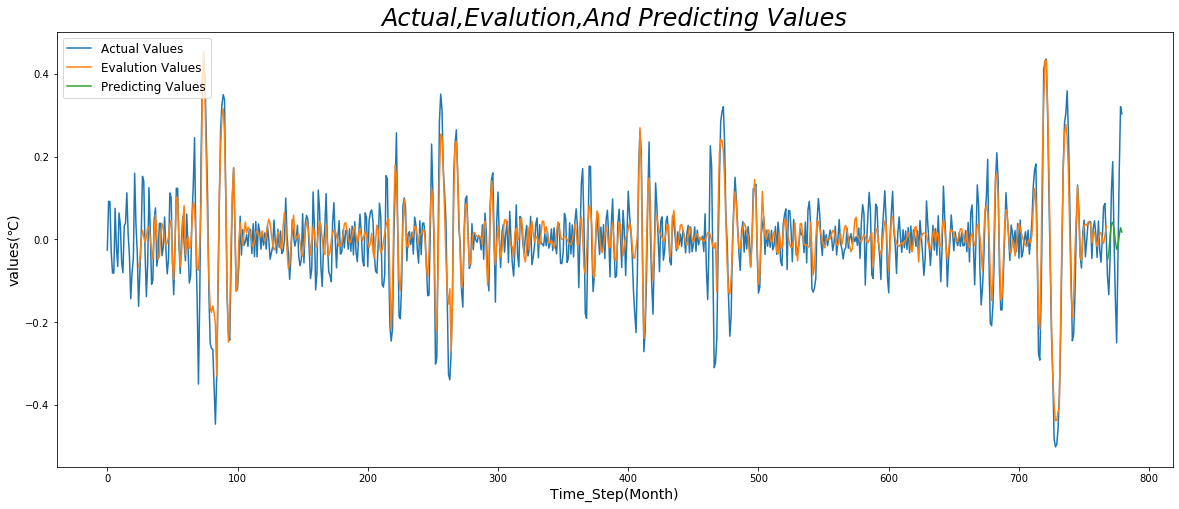

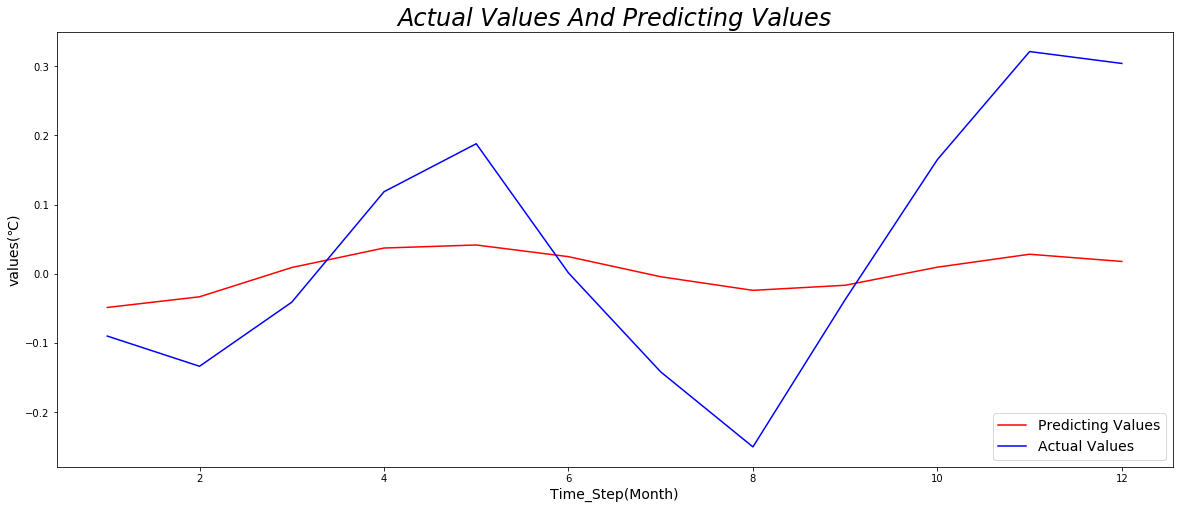

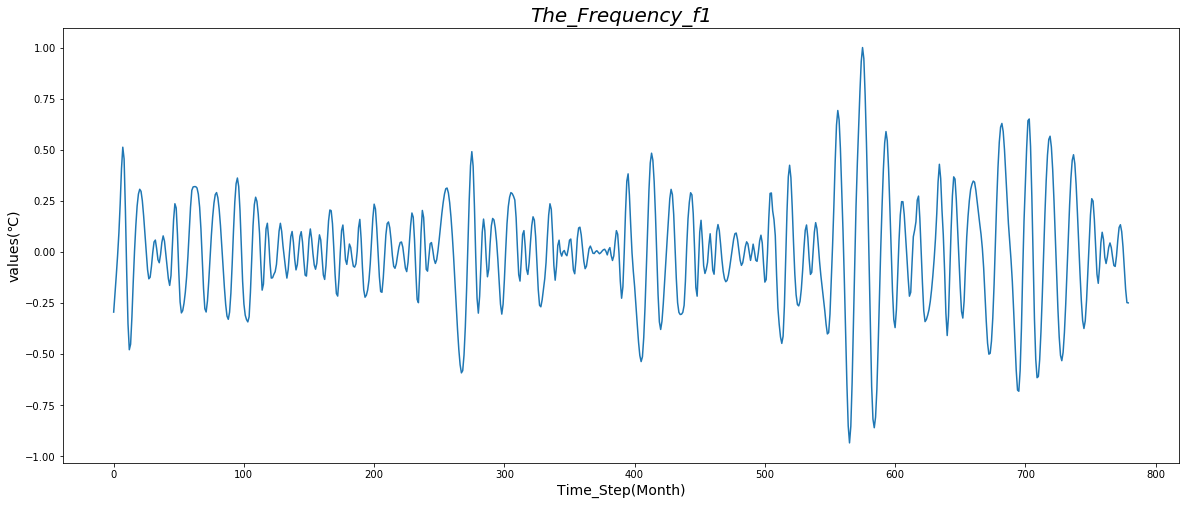

Epoch 1/200
 - 21s - loss: 0.0662
Epoch 2/200
 - 4s - loss: 0.0592
Epoch 3/200
 - 4s - loss: 0.0523
Epoch 4/200
 - 4s - loss: 0.0431
Epoch 5/200
 - 4s - loss: 0.0416
Epoch 6/200
 - 4s - loss: 0.0408
Epoch 7/200
 - 4s - loss: 0.0388
Epoch 8/200
 - 4s - loss: 0.0394
Epoch 9/200
 - 4s - loss: 0.0378
Epoch 10/200
 - 3s - loss: 0.0365
Epoch 11/200
 - 2s - loss: 0.0344
Epoch 12/200
 - 2s - loss: 0.0337
Epoch 13/200
 - 2s - loss: 0.0325
Epoch 14/200
 - 2s - loss: 0.0321
Epoch 15/200
 - 2s - loss: 0.0322
Epoch 16/200
 - 2s - loss: 0.0312
Epoch 17/200
 - 2s - loss: 0.0305
Epoch 18/200
 - 2s - loss: 0.0312
Epoch 19/200
 - 2s - loss: 0.0304
Epoch 20/200
 - 2s - loss: 0.0288
Epoch 21/200
 - 2s - loss: 0.0285
Epoch 22/200
 - 2s - loss: 0.0296
Epoch 23/200
 - 2s - loss: 0.0294
Epoch 24/200
 - 2s - loss: 0.0295
Epoch 25/200
 - 2s - loss: 0.0284
Epoch 26/200
 - 2s - loss: 0.0282
Epoch 27/200
 - 2s - loss: 0.0288
Epoch 28/200
 - 2s - loss: 0.0281
Epoch 29/200
 - 2s - loss: 0.0267
Epoch 30/200
 - 3s - l

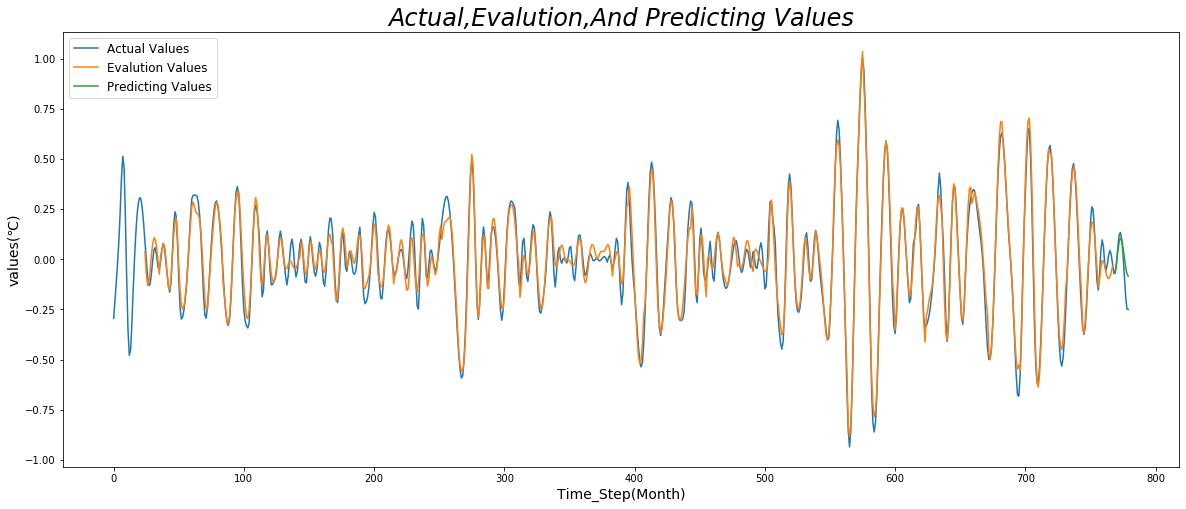

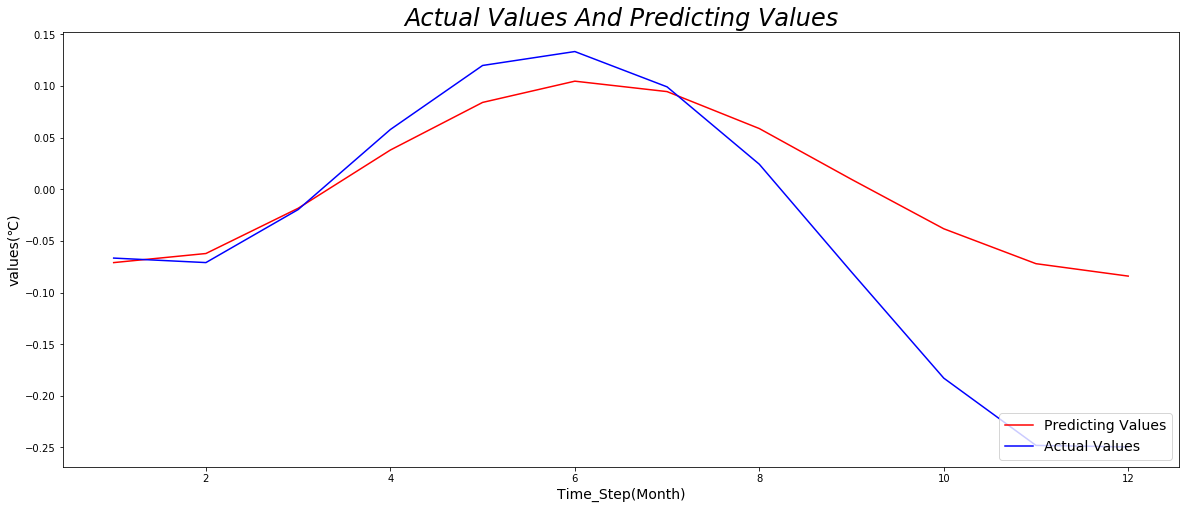

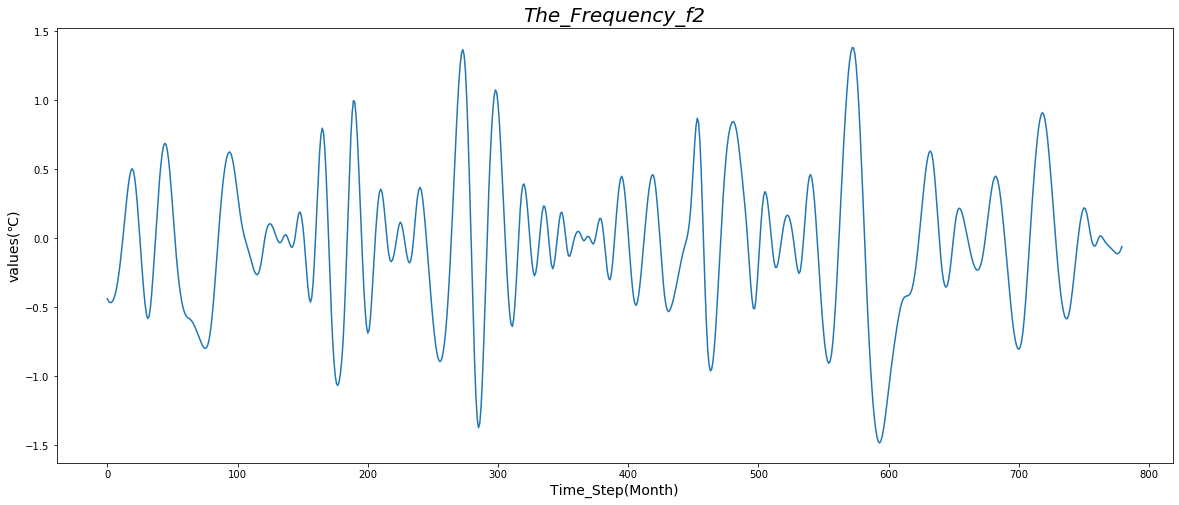

Epoch 1/200
 - 14s - loss: 0.2486
Epoch 2/200
 - 3s - loss: 0.2333
Epoch 3/200
 - 3s - loss: 0.2047
Epoch 4/200
 - 3s - loss: 0.1768
Epoch 5/200
 - 3s - loss: 0.1352
Epoch 6/200
 - 3s - loss: 0.1549
Epoch 7/200
 - 3s - loss: 0.1180
Epoch 8/200
 - 4s - loss: 0.1162
Epoch 9/200
 - 4s - loss: 0.1032
Epoch 10/200
 - 4s - loss: 0.0924
Epoch 11/200
 - 4s - loss: 0.0878
Epoch 12/200
 - 4s - loss: 0.0822
Epoch 13/200
 - 4s - loss: 0.0780
Epoch 14/200
 - 4s - loss: 0.0747
Epoch 15/200
 - 4s - loss: 0.0756
Epoch 16/200
 - 4s - loss: 0.0672
Epoch 17/200
 - 4s - loss: 0.0693
Epoch 18/200
 - 4s - loss: 0.0625
Epoch 19/200
 - 4s - loss: 0.0612
Epoch 20/200
 - 4s - loss: 0.0575
Epoch 21/200
 - 4s - loss: 0.0532
Epoch 22/200
 - 4s - loss: 0.0593
Epoch 23/200
 - 4s - loss: 0.0600
Epoch 24/200
 - 4s - loss: 0.0523
Epoch 25/200
 - 4s - loss: 0.0539
Epoch 26/200
 - 4s - loss: 0.0582
Epoch 27/200
 - 4s - loss: 0.0562
Epoch 28/200
 - 4s - loss: 0.0536
Epoch 29/200
 - 4s - loss: 0.0575
Epoch 30/200
 - 4s - l

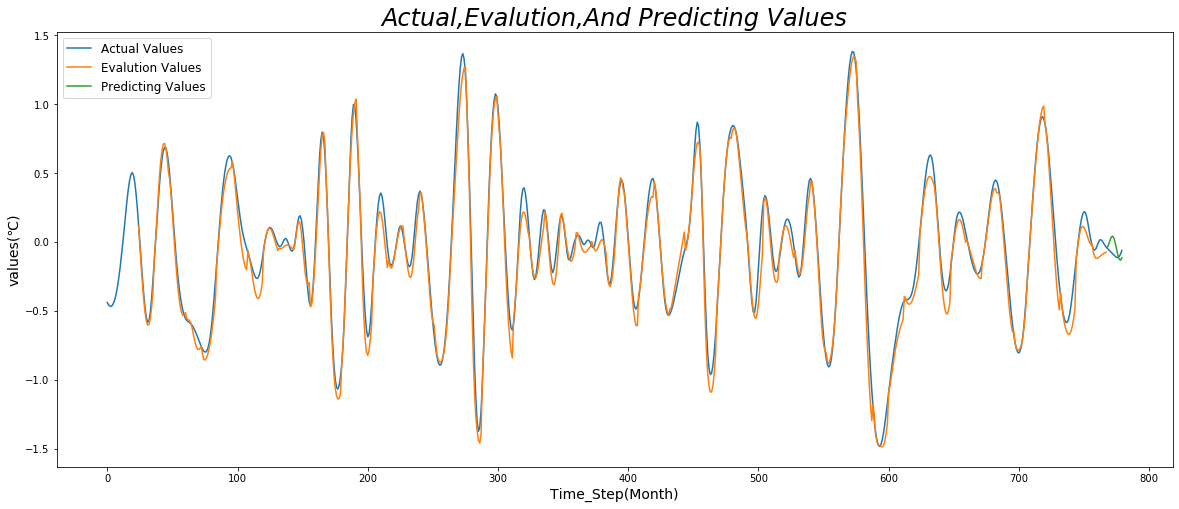

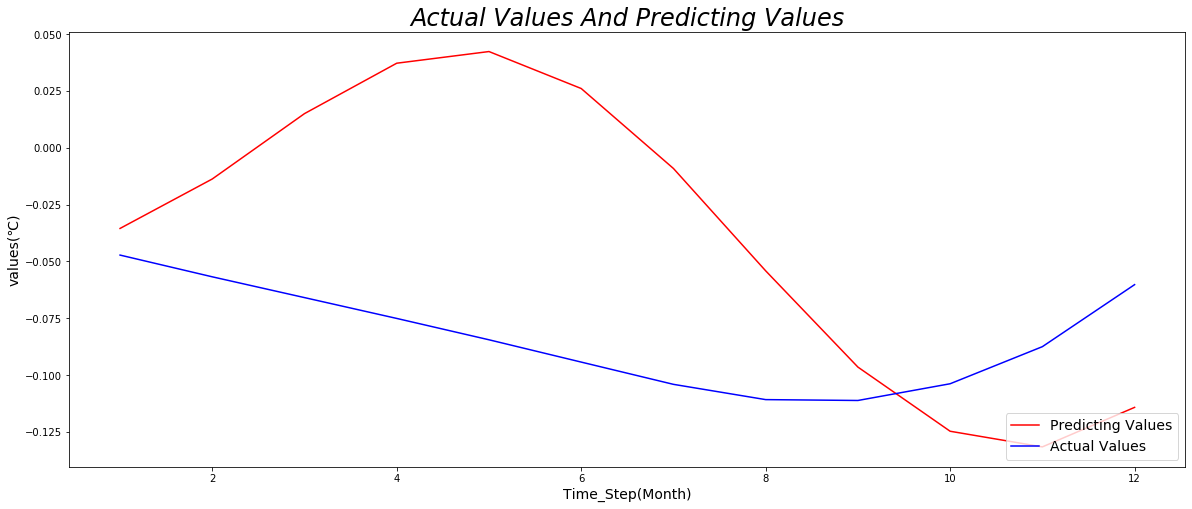

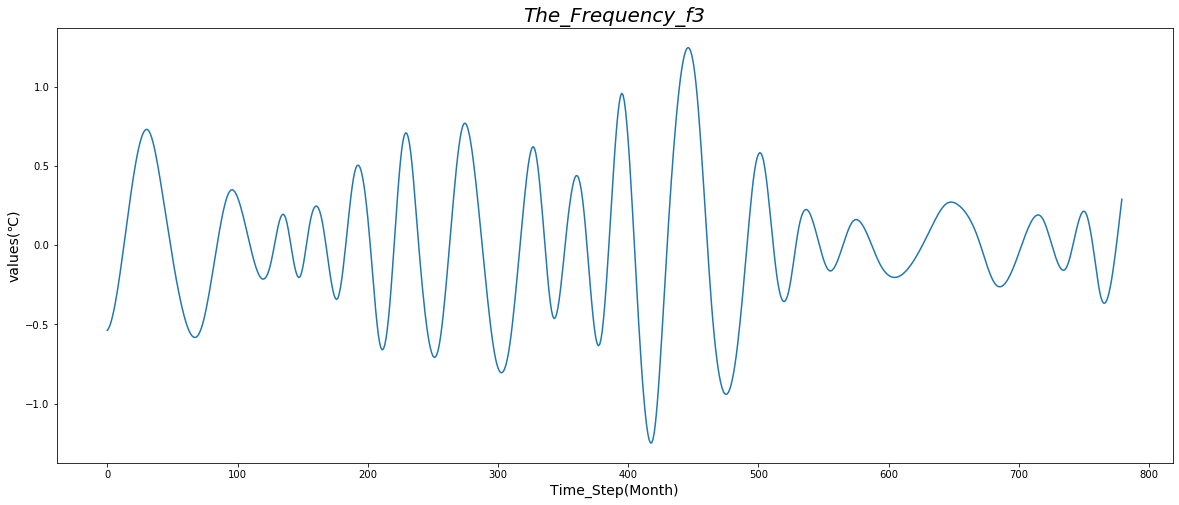

Epoch 1/200
 - 10s - loss: 0.1524
Epoch 2/200
 - 5s - loss: 0.1169
Epoch 3/200
 - 5s - loss: 0.0897
Epoch 4/200
 - 5s - loss: 0.0645
Epoch 5/200
 - 5s - loss: 0.0548
Epoch 6/200
 - 5s - loss: 0.0387
Epoch 7/200
 - 5s - loss: 0.0307
Epoch 8/200
 - 5s - loss: 0.0268
Epoch 9/200
 - 5s - loss: 0.0245
Epoch 10/200
 - 5s - loss: 0.0222
Epoch 11/200
 - 5s - loss: 0.0209
Epoch 12/200
 - 5s - loss: 0.0185
Epoch 13/200
 - 5s - loss: 0.0203
Epoch 14/200
 - 5s - loss: 0.0200
Epoch 15/200
 - 5s - loss: 0.0180
Epoch 16/200
 - 5s - loss: 0.0198
Epoch 17/200
 - 5s - loss: 0.0152
Epoch 18/200
 - 5s - loss: 0.0132
Epoch 19/200
 - 5s - loss: 0.0116
Epoch 20/200
 - 5s - loss: 0.0140
Epoch 21/200
 - 5s - loss: 0.0115
Epoch 22/200
 - 5s - loss: 0.0149
Epoch 23/200
 - 5s - loss: 0.0187
Epoch 24/200
 - 5s - loss: 0.0185
Epoch 25/200
 - 5s - loss: 0.0154
Epoch 26/200
 - 5s - loss: 0.0109
Epoch 27/200
 - 5s - loss: 0.0111
Epoch 28/200
 - 5s - loss: 0.0118
Epoch 29/200
 - 5s - loss: 0.0108
Epoch 30/200
 - 5s - l

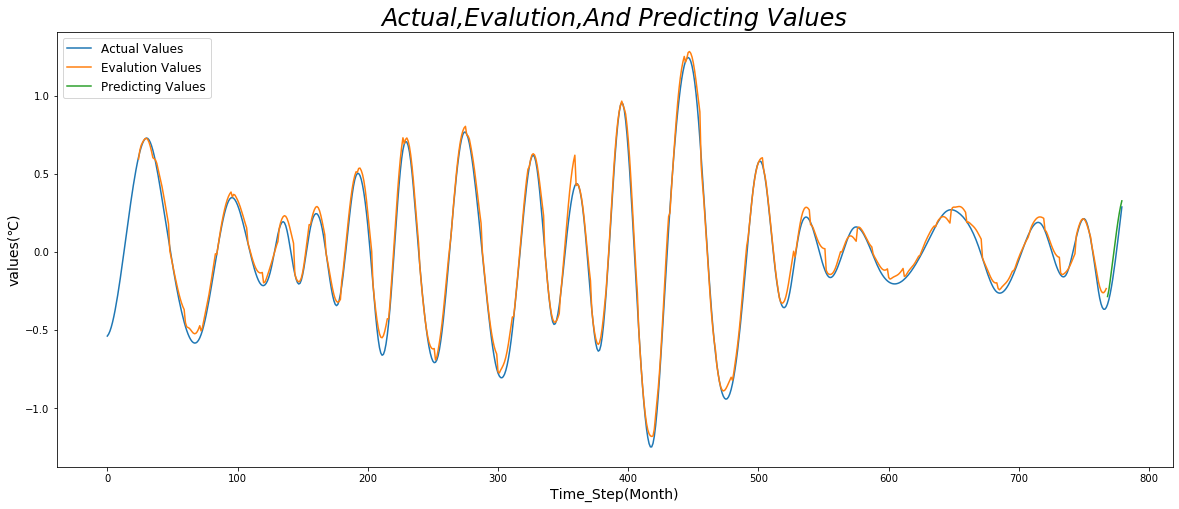

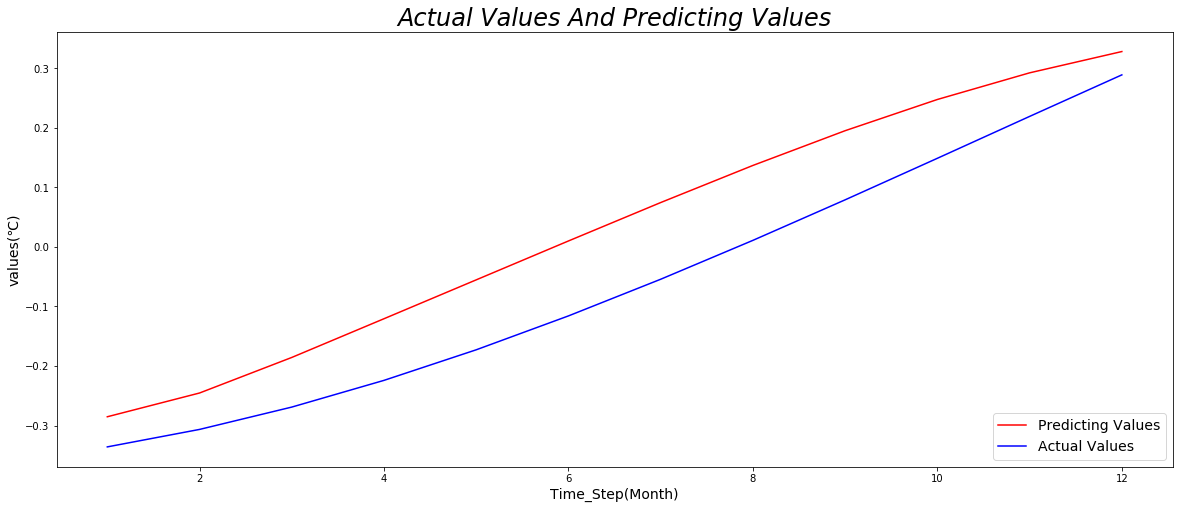

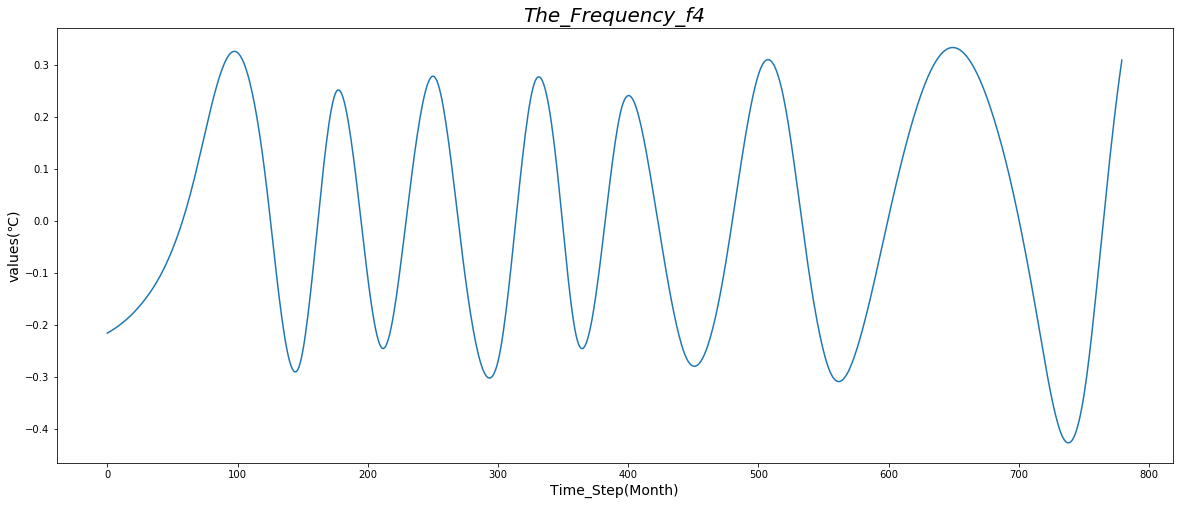

Epoch 1/200
 - 12s - loss: 0.0340
Epoch 2/200
 - 6s - loss: 0.0103
Epoch 3/200
 - 6s - loss: 0.0065
Epoch 4/200
 - 5s - loss: 0.0048
Epoch 5/200
 - 5s - loss: 0.0033
Epoch 6/200
 - 5s - loss: 0.0035
Epoch 7/200
 - 5s - loss: 0.0027
Epoch 8/200
 - 5s - loss: 0.0021
Epoch 9/200
 - 5s - loss: 0.0018
Epoch 10/200
 - 5s - loss: 0.0015
Epoch 11/200
 - 5s - loss: 0.0015
Epoch 12/200
 - 5s - loss: 0.0014
Epoch 13/200
 - 5s - loss: 0.0013
Epoch 14/200
 - 5s - loss: 0.0018
Epoch 15/200
 - 5s - loss: 0.0015
Epoch 16/200
 - 5s - loss: 0.0016
Epoch 17/200
 - 5s - loss: 0.0017
Epoch 18/200
 - 6s - loss: 0.0017
Epoch 19/200
 - 5s - loss: 0.0013
Epoch 20/200
 - 5s - loss: 0.0014
Epoch 21/200
 - 5s - loss: 0.0011
Epoch 22/200
 - 5s - loss: 0.0016
Epoch 23/200
 - 5s - loss: 0.0013
Epoch 24/200
 - 5s - loss: 0.0011
Epoch 25/200
 - 5s - loss: 0.0011
Epoch 26/200
 - 5s - loss: 0.0012
Epoch 27/200
 - 5s - loss: 9.3797e-04
Epoch 28/200
 - 5s - loss: 9.2426e-04
Epoch 29/200
 - 5s - loss: 0.0011
Epoch 30/200
 

(62, 12)


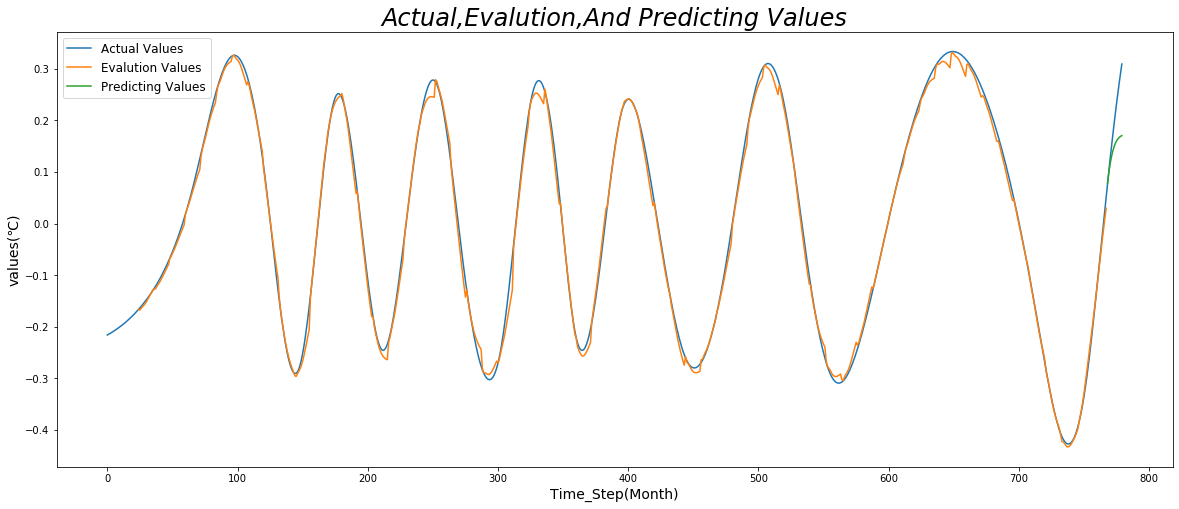

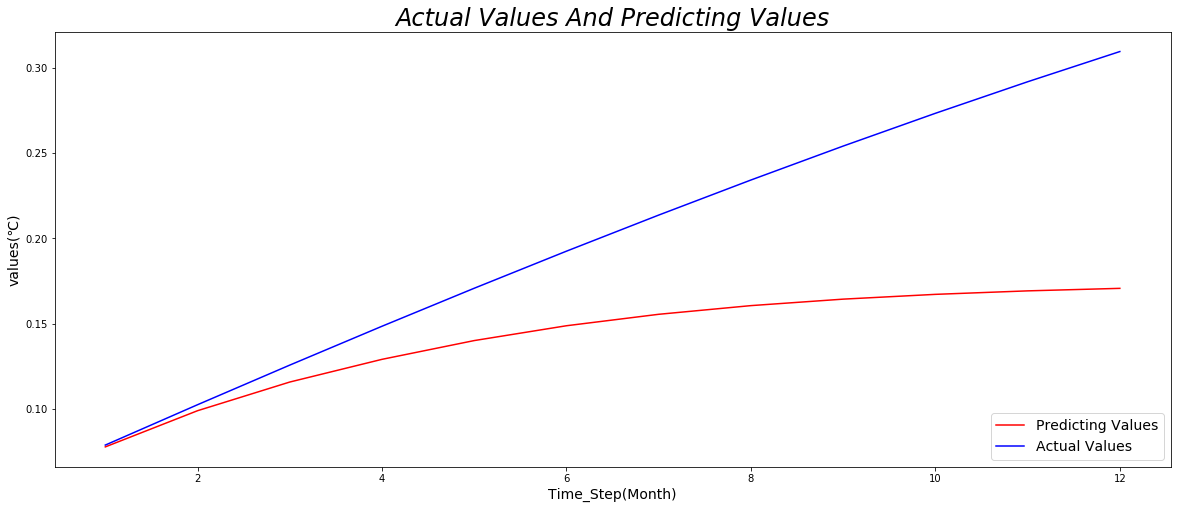

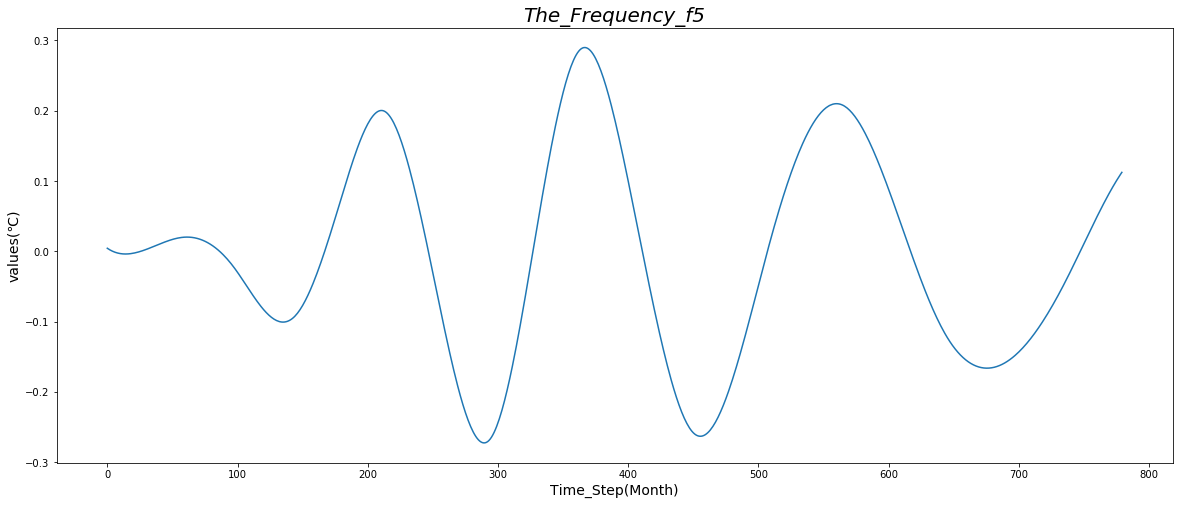

Epoch 1/200
 - 12s - loss: 0.0122
Epoch 2/200
 - 6s - loss: 0.0037
Epoch 3/200
 - 6s - loss: 0.0016
Epoch 4/200
 - 6s - loss: 8.3672e-04
Epoch 5/200
 - 6s - loss: 6.2195e-04
Epoch 6/200
 - 6s - loss: 5.2184e-04
Epoch 7/200
 - 6s - loss: 5.1587e-04
Epoch 8/200
 - 6s - loss: 4.0331e-04
Epoch 9/200
 - 6s - loss: 4.1583e-04
Epoch 10/200
 - 6s - loss: 4.2782e-04
Epoch 11/200
 - 6s - loss: 4.5918e-04
Epoch 12/200
 - 6s - loss: 5.4585e-04
Epoch 13/200
 - 6s - loss: 5.3380e-04
Epoch 14/200
 - 6s - loss: 4.2971e-04
Epoch 15/200
 - 6s - loss: 3.6486e-04
Epoch 16/200
 - 6s - loss: 4.1972e-04
Epoch 17/200
 - 6s - loss: 2.9989e-04
Epoch 18/200
 - 6s - loss: 3.1518e-04
Epoch 19/200
 - 6s - loss: 3.7527e-04
Epoch 20/200
 - 6s - loss: 3.2328e-04
Epoch 21/200
 - 6s - loss: 3.2637e-04
Epoch 22/200
 - 6s - loss: 3.3275e-04
Epoch 23/200
 - 6s - loss: 3.4601e-04
Epoch 24/200
 - 6s - loss: 2.9415e-04
Epoch 25/200
 - 6s - loss: 3.4601e-04
Epoch 26/200
 - 6s - loss: 4.7382e-04
Epoch 27/200
 - 6s - loss: 5.522

(62, 12)


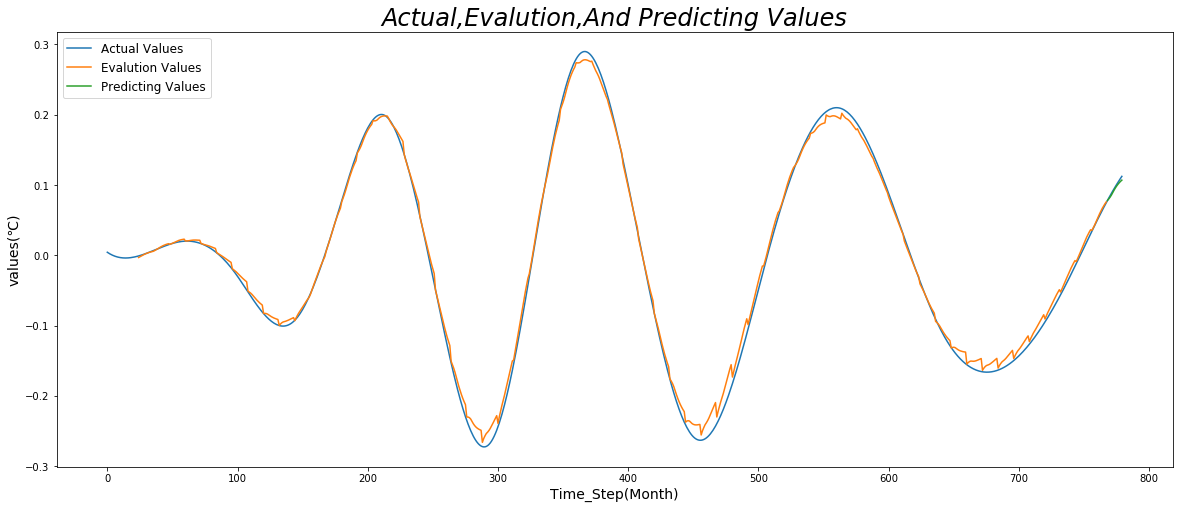

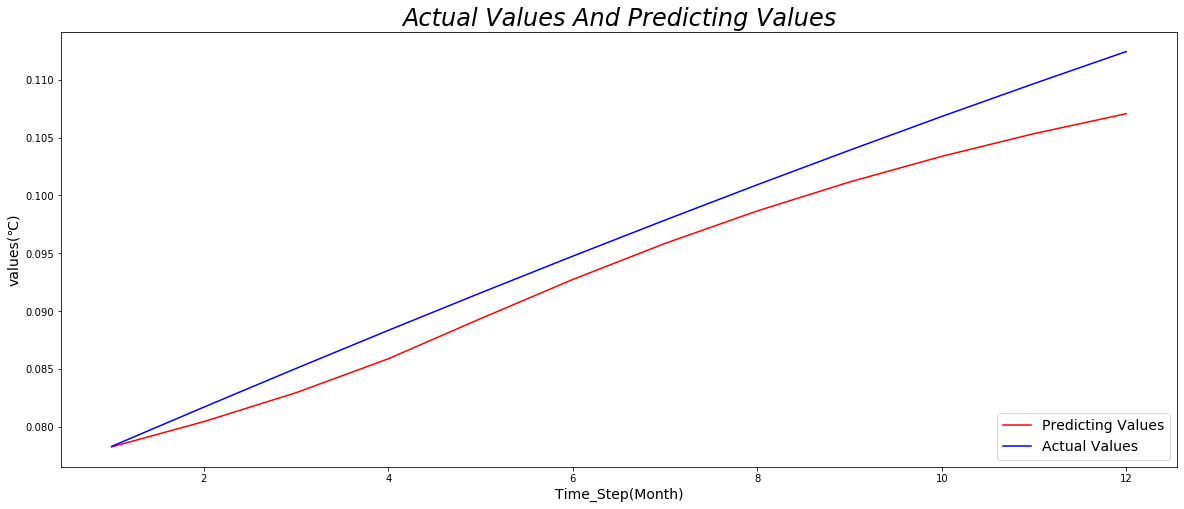

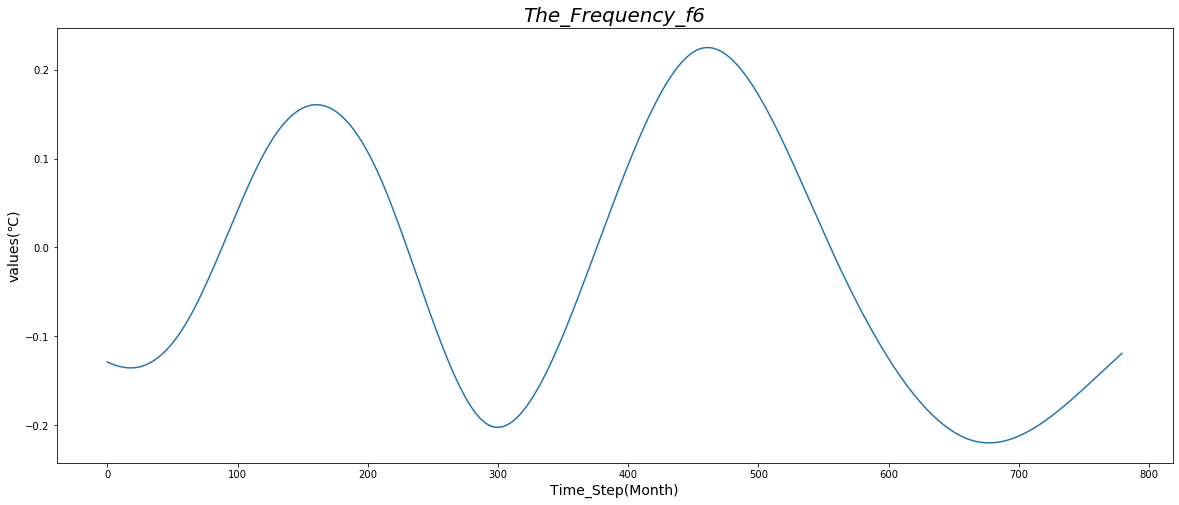

Epoch 1/200
 - 11s - loss: 0.0086
Epoch 2/200
 - 7s - loss: 0.0034
Epoch 3/200
 - 7s - loss: 0.0015
Epoch 4/200
 - 7s - loss: 7.3298e-04
Epoch 5/200
 - 7s - loss: 5.3502e-04
Epoch 6/200
 - 7s - loss: 4.5303e-04
Epoch 7/200
 - 7s - loss: 4.8759e-04
Epoch 8/200
 - 7s - loss: 3.3041e-04
Epoch 9/200
 - 7s - loss: 2.9891e-04
Epoch 10/200
 - 7s - loss: 3.6456e-04
Epoch 11/200
 - 7s - loss: 3.6831e-04
Epoch 12/200
 - 7s - loss: 3.2344e-04
Epoch 13/200
 - 7s - loss: 3.0857e-04
Epoch 14/200
 - 7s - loss: 2.7023e-04
Epoch 15/200
 - 7s - loss: 3.3690e-04
Epoch 16/200
 - 7s - loss: 2.5955e-04
Epoch 17/200
 - 7s - loss: 2.5032e-04
Epoch 18/200
 - 7s - loss: 2.7541e-04
Epoch 19/200
 - 7s - loss: 2.6450e-04
Epoch 20/200
 - 7s - loss: 3.1155e-04
Epoch 21/200
 - 7s - loss: 2.6660e-04
Epoch 22/200
 - 7s - loss: 2.4312e-04
Epoch 23/200
 - 7s - loss: 2.6245e-04
Epoch 24/200
 - 7s - loss: 2.2821e-04
Epoch 25/200
 - 7s - loss: 3.0522e-04
Epoch 26/200
 - 7s - loss: 4.1446e-04
Epoch 27/200
 - 7s - loss: 2.799

(62, 12)


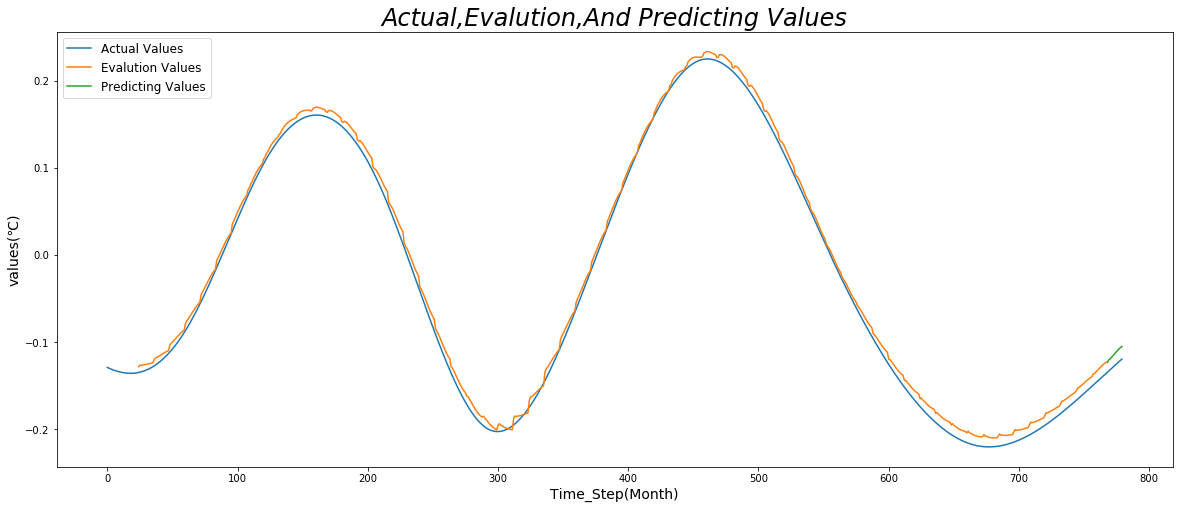

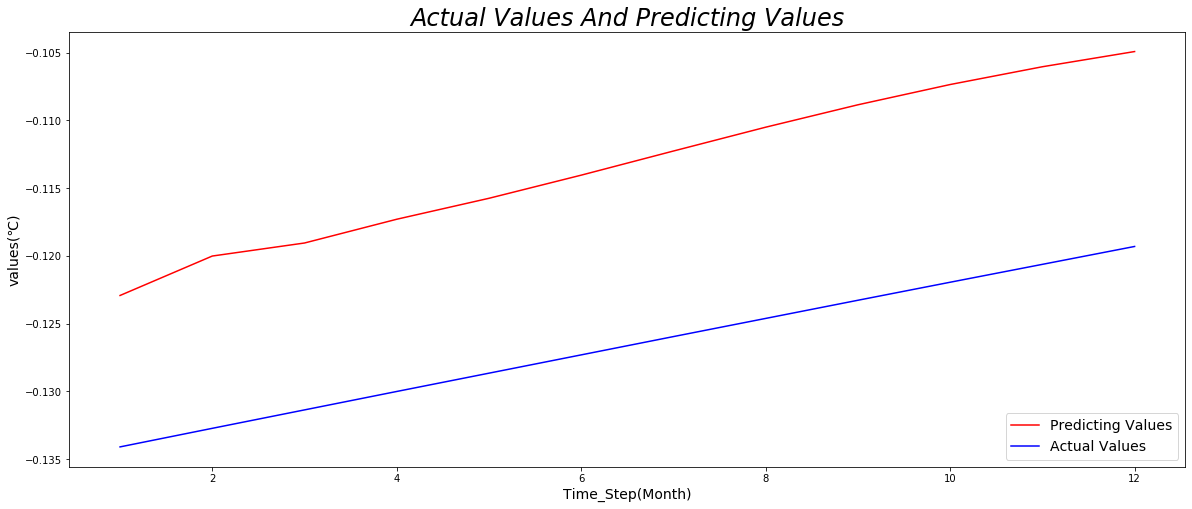

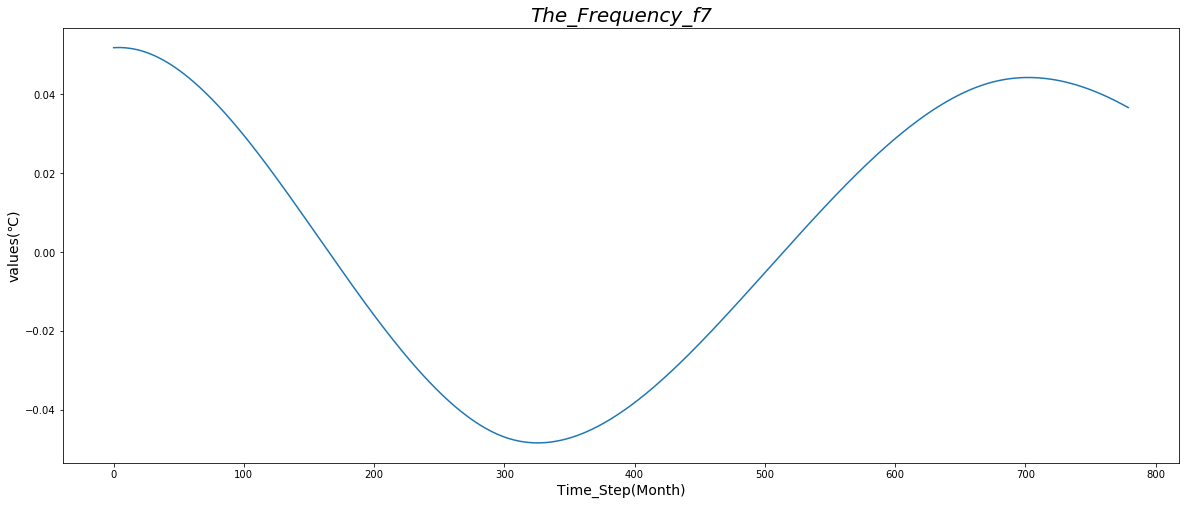

Epoch 1/200
 - 14s - loss: 9.1672e-04
Epoch 2/200
 - 7s - loss: 2.7014e-04
Epoch 3/200
 - 7s - loss: 1.4975e-04
Epoch 4/200
 - 7s - loss: 1.0392e-04
Epoch 5/200
 - 7s - loss: 7.8357e-05
Epoch 6/200
 - 7s - loss: 6.7734e-05
Epoch 7/200
 - 7s - loss: 5.8937e-05
Epoch 8/200
 - 7s - loss: 5.9631e-05
Epoch 9/200
 - 7s - loss: 4.8528e-05
Epoch 10/200
 - 7s - loss: 4.5049e-05
Epoch 11/200
 - 7s - loss: 4.0204e-05
Epoch 12/200
 - 7s - loss: 3.9926e-05
Epoch 13/200
 - 7s - loss: 3.6695e-05
Epoch 14/200
 - 7s - loss: 3.7699e-05
Epoch 15/200
 - 7s - loss: 3.4519e-05
Epoch 16/200
 - 7s - loss: 4.4368e-05
Epoch 17/200
 - 7s - loss: 3.5774e-05
Epoch 18/200
 - 7s - loss: 2.9997e-05
Epoch 19/200
 - 7s - loss: 2.0939e-05
Epoch 20/200
 - 7s - loss: 1.7115e-05
Epoch 21/200
 - 7s - loss: 2.4361e-05
Epoch 22/200
 - 7s - loss: 2.2348e-05
Epoch 23/200
 - 7s - loss: 1.8547e-05
Epoch 24/200
 - 7s - loss: 1.7514e-05
Epoch 25/200
 - 7s - loss: 1.5437e-05
Epoch 26/200
 - 7s - loss: 1.5442e-05
Epoch 27/200
 - 7s -

(62, 12)


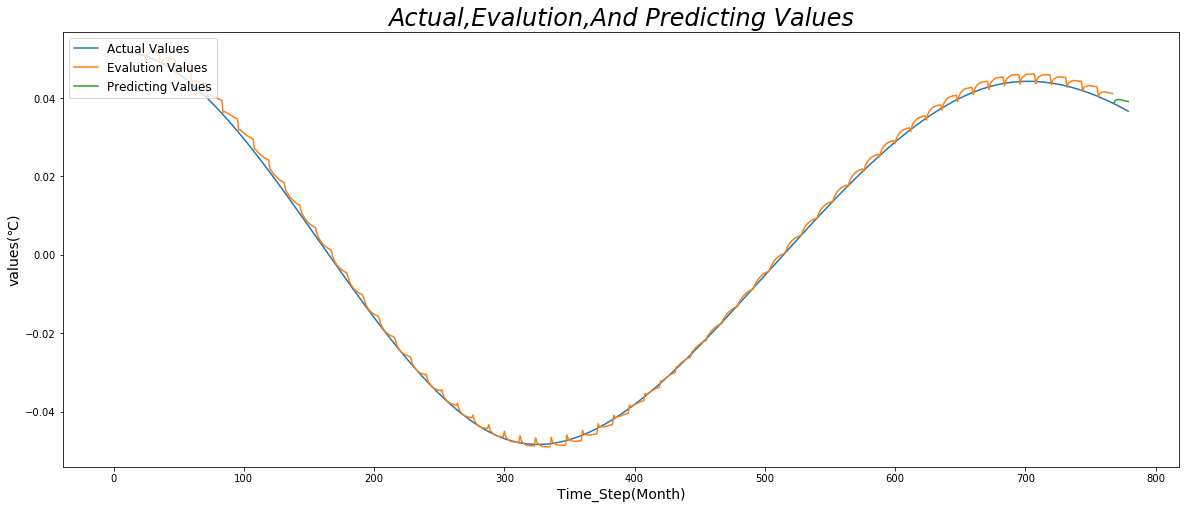

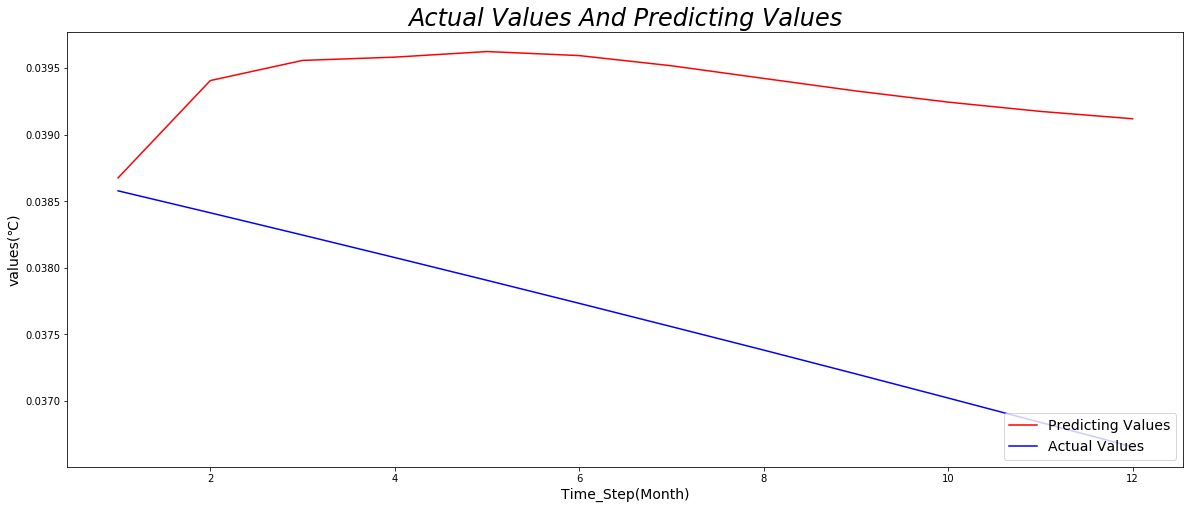

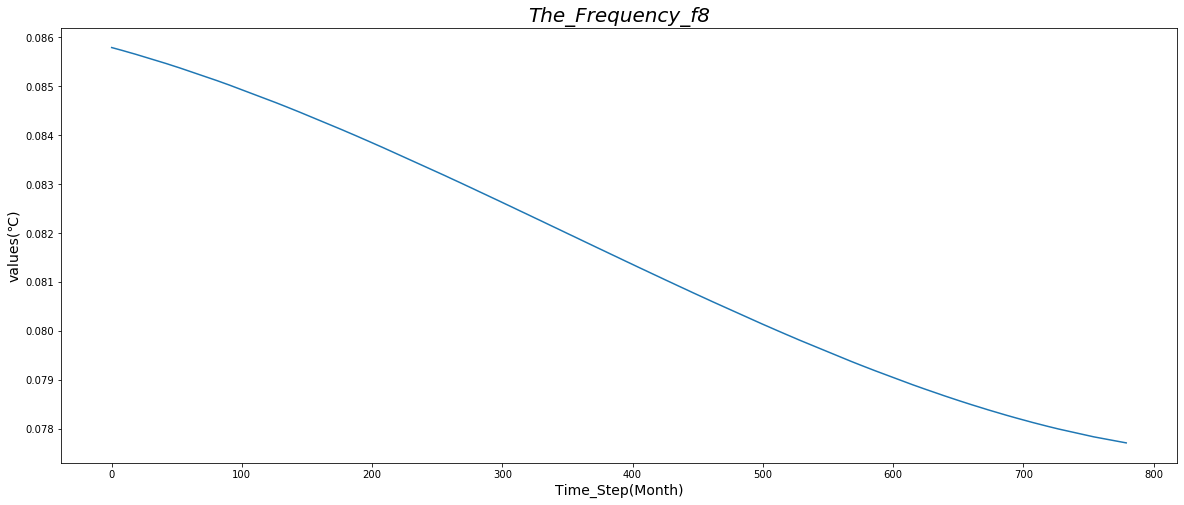

Epoch 1/200
 - 14s - loss: 5.6402e-04
Epoch 2/200
 - 7s - loss: 1.6332e-05
Epoch 3/200
 - 7s - loss: 7.9569e-06
Epoch 4/200
 - 7s - loss: 7.1735e-06
Epoch 5/200
 - 7s - loss: 6.7078e-06
Epoch 6/200
 - 7s - loss: 6.6213e-06
Epoch 7/200
 - 7s - loss: 6.6163e-06
Epoch 8/200
 - 7s - loss: 6.5013e-06
Epoch 9/200
 - 7s - loss: 6.6200e-06
Epoch 10/200
 - 7s - loss: 6.2762e-06
Epoch 11/200
 - 7s - loss: 6.4265e-06
Epoch 12/200
 - 7s - loss: 6.7825e-06
Epoch 13/200
 - 7s - loss: 6.2806e-06
Epoch 14/200
 - 7s - loss: 6.4030e-06
Epoch 15/200
 - 7s - loss: 6.2870e-06
Epoch 16/200
 - 7s - loss: 6.6146e-06
Epoch 17/200
 - 7s - loss: 6.4102e-06
Epoch 18/200
 - 7s - loss: 6.9929e-06
Epoch 19/200
 - 7s - loss: 7.3778e-06
Epoch 20/200
 - 7s - loss: 6.3028e-06
Epoch 21/200
 - 7s - loss: 6.3322e-06
Epoch 22/200
 - 7s - loss: 6.7251e-06
Epoch 23/200
 - 7s - loss: 6.3919e-06
Epoch 24/200
 - 7s - loss: 6.0372e-06
Epoch 25/200
 - 7s - loss: 6.3707e-06
Epoch 26/200
 - 7s - loss: 6.0548e-06
Epoch 27/200
 - 7s -

(62, 12)


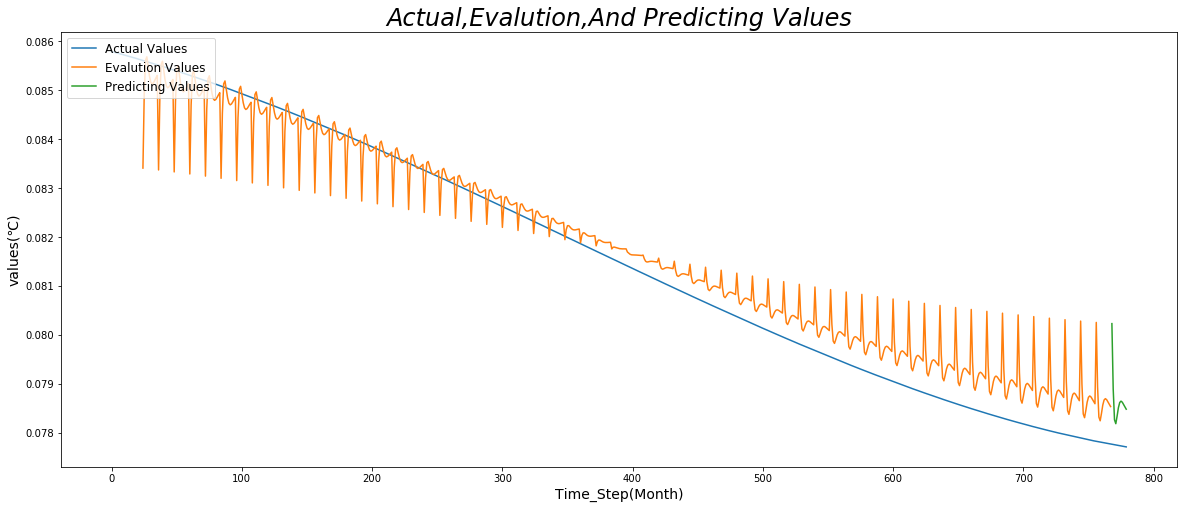

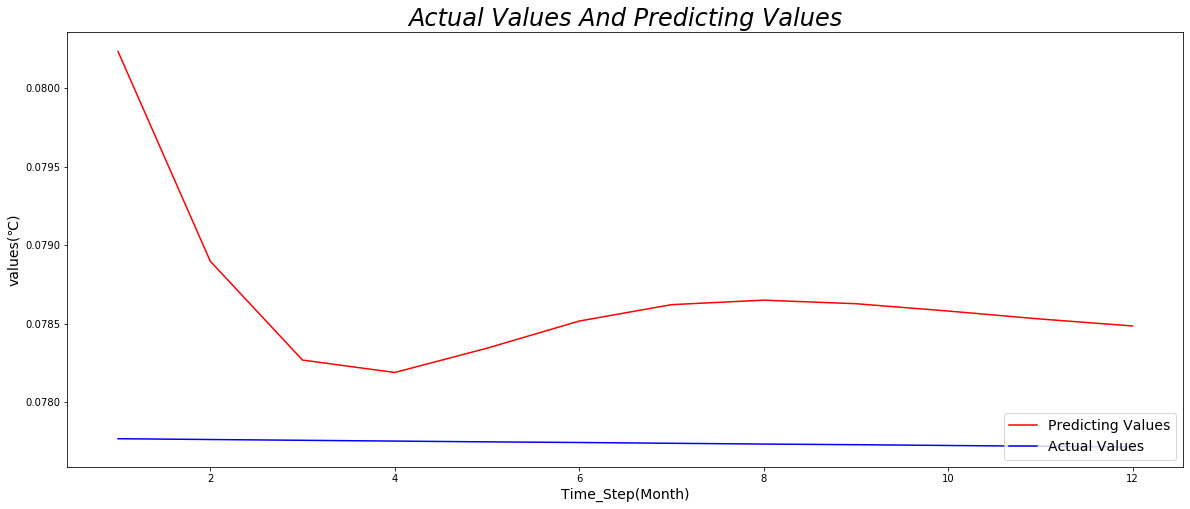

In [7]:
for i in range(9):
    index_name="f"+str(i)
    dataset = df[index_name][:-48]

    plt.figure(figsize=(20,8))
    plt.plot(dataset)
    plt.title('The_Frequency_{0}'.format(index_name),fontstyle="italic",fontsize=20)    
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/The_Frequency_{0}'.format(index_name))
    plt.show() 
    
    #train, test = split_dataset(dataset.values)
    #train=train.reshape(train.shape[0],train.shape[1],1)
    #test=test.reshape(test.shape[0],train.shape[1],1)
    train, test = split_dataset(dataset.values)
    train=train.reshape(train.shape[0],train.shape[1],1)
    test=test.reshape(test.shape[0],train.shape[1],1)
    
    n_steps, n_length = 2, 12
    n_input = n_length * n_steps
    n_out=12
    
    train_x, train_y = to_supervised(train, n_input,n_out)

    
    model=build_model(train_x,train_y,n_input,n_out,n_steps, n_length)
    score, scores,predictions = evaluate_model(train, test, n_input,n_steps, n_length)
    
    
    #trainPredict = model.predict(train)
    #print (predictions.reshape(-1))
    
    trainPredict=[]
    for index_train_predict in range(train.shape[0]-2):
        input_x=train.reshape(-1)[12*index_train_predict:(index_train_predict+2)*12]
        input_x = input_x.reshape((1, n_steps,1,n_length, 1))
        yhat = model.predict(input_x, verbose=0)
        trainPredict.append(yhat)

    trainPredict=np.array(trainPredict)
    trainPredict=trainPredict.reshape(trainPredict.shape[0],trainPredict.shape[2])
    print (trainPredict.shape)


    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:] = np.nan
    #trainPredictPlot[12:len(trainPredict.reshape(-1))+12] = trainPredict.reshape(-1)
    trainPredictPlot[24:len(trainPredict.reshape(-1))+12*2] = trainPredict.reshape(-1)
    
# shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:] = np.nan
    testPredictPlot[len(trainPredict.reshape(-1))+24:len(dataset)] = predictions.reshape(-1)
#testPredictPlot[len(trainPredict)+look_back+1:len(dataset)-1] = testPredict.reshape(-1)
# plot baseline and predictions

        
    plt.figure(figsize=(20,8))
    plt.title("Actual,Evalution,And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(dataset,label='Actual Values')
    plt.plot(trainPredictPlot,label='Evalution Values')
    plt.plot(testPredictPlot,label='Predicting Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=2,fontsize=12)
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_whole_result_{0}.png'.format(index_name))
    plt.show() 
    
    plt.figure(figsize=(20,8))
    index_start = np.array(range(1,13))
    plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(index_start,predictions[0],color="red",label='Predicting Values')
    plt.plot(index_start,dataset[-12::].values,color="blue",label='Actual Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=4,fontsize=14) 
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_predict_result_{0}.png'.format(index_name))
    plt.show() 
    
    dataset_in_one.append(dataset)
    train_prediciton_in_one.append(trainPredict.reshape(-1))
    real_in_one.append(dataset[-12::].values)
    prediction_in_one.append(predictions[0])


In [8]:
#backing up for the results
print (predictions[0])
print (real_in_one)
print (prediction_in_one)
back_real_in_one=real_in_one
back_prediction_in_one=prediction_in_one

[[0.08023234]
 [0.07889674]
 [0.07826714]
 [0.07818798]
 [0.07834252]
 [0.07851552]
 [0.07862   ]
 [0.07864875]
 [0.07862604]
 [0.07857943]
 [0.07852865]
 [0.07848427]]
[array([-0.089894 , -0.13353  , -0.040963 ,  0.1186   ,  0.18799  ,
        0.0013725, -0.14162  , -0.25001  , -0.037291 ,  0.16508  ,
        0.32117  ,  0.30398  ]), array([-0.066672, -0.071024, -0.019692,  0.057821,  0.11983 ,  0.13331 ,
        0.099123,  0.024204, -0.080189, -0.1829  , -0.24804 , -0.24948 ]), array([-0.047196, -0.05676 , -0.065907, -0.075071, -0.084464, -0.094279,
       -0.10407 , -0.11079 , -0.11117 , -0.10381 , -0.087494, -0.060201]), array([-0.33567 , -0.30635 , -0.26886 , -0.22402 , -0.1727  , -0.11583 ,
       -0.054297,  0.010972,  0.079005,  0.14871 ,  0.21899 ,  0.28871 ]), array([0.078862, 0.10251 , 0.12573 , 0.1485  , 0.17077 , 0.1925  ,
       0.21365 , 0.2342  , 0.25409 , 0.2733  , 0.29178 , 0.30949 ]), array([0.078314, 0.081709, 0.085052, 0.088342, 0.091576, 0.094752,
       0.097867,

In [9]:
true_values=np.zeros((12,1))

for i in range(len(prediction_in_one)):
 
    print ("observe value:{0}".format(real_in_one[i]))
    #print (np.array(real_in_one[i]).reshape(12,1))
    true_values=true_values+np.array(real_in_one[i].reshape(12,1))
    print (true_values)
    round_true_values=np.round(true_values,2)
    print (round_true_values)
    
    print ("-----------------------------------")

observe value:[-0.089894  -0.13353   -0.040963   0.1186     0.18799    0.0013725
 -0.14162   -0.25001   -0.037291   0.16508    0.32117    0.30398  ]
[[-0.089894 ]
 [-0.13353  ]
 [-0.040963 ]
 [ 0.1186   ]
 [ 0.18799  ]
 [ 0.0013725]
 [-0.14162  ]
 [-0.25001  ]
 [-0.037291 ]
 [ 0.16508  ]
 [ 0.32117  ]
 [ 0.30398  ]]
[[-0.09]
 [-0.13]
 [-0.04]
 [ 0.12]
 [ 0.19]
 [ 0.  ]
 [-0.14]
 [-0.25]
 [-0.04]
 [ 0.17]
 [ 0.32]
 [ 0.3 ]]
-----------------------------------
observe value:[-0.066672 -0.071024 -0.019692  0.057821  0.11983   0.13331   0.099123
  0.024204 -0.080189 -0.1829   -0.24804  -0.24948 ]
[[-0.156566 ]
 [-0.204554 ]
 [-0.060655 ]
 [ 0.176421 ]
 [ 0.30782  ]
 [ 0.1346825]
 [-0.042497 ]
 [-0.225806 ]
 [-0.11748  ]
 [-0.01782  ]
 [ 0.07313  ]
 [ 0.0545   ]]
[[-0.16]
 [-0.2 ]
 [-0.06]
 [ 0.18]
 [ 0.31]
 [ 0.13]
 [-0.04]
 [-0.23]
 [-0.12]
 [-0.02]
 [ 0.07]
 [ 0.05]]
-----------------------------------
observe value:[-0.047196 -0.05676  -0.065907 -0.075071 -0.084464 -0.094279 -0.10407
 -

In [10]:
predicted_values=np.zeros((12))
print (predicted_values)
for i in range(len(prediction_in_one)):
    print ("the {0} frequence:".format(i))    
    print ("predicted_value:{0}".format(prediction_in_one[i].reshape(-1)))
    predicted_values = np.add(predicted_values, prediction_in_one[i].reshape(-1))
    print (predicted_values)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
the 0 frequence:
predicted_value:[-0.04857307 -0.03315317  0.00913958  0.0373045   0.04168967  0.02483482
 -0.00416314 -0.02384231 -0.01649902  0.00962271  0.0283222   0.01792213]
[-0.04857307 -0.03315317  0.00913958  0.0373045   0.04168967  0.02483482
 -0.00416314 -0.02384231 -0.01649902  0.00962271  0.0283222   0.01792213]
the 1 frequence:
predicted_value:[-0.07104263 -0.06224197 -0.01844134  0.03794887  0.08405434  0.10462317
  0.09452941  0.05875359  0.00955194 -0.03828589 -0.07209004 -0.08411697]
[-0.1196157  -0.09539514 -0.00930176  0.07525337  0.125744    0.12945799
  0.09036627  0.03491129 -0.00694707 -0.02866318 -0.04376784 -0.06619483]
the 2 frequence:
predicted_value:[-0.03547306 -0.01370913  0.01505432  0.03722887  0.04235905  0.0260934
 -0.00908986 -0.05412637 -0.09647536 -0.12470853 -0.13159233 -0.11420307]
[-0.15508876 -0.10910427  0.00575256  0.11248225  0.16810305  0.15555139
  0.08127641 -0.01921508 -0.10342244 -0.15337171 -0.1753

[[-0.4]
 [-0.4]
 [-0.2]
 [ 0.1]
 [ 0.3]
 [ 0.2]
 [ 0.1]
 [-0. ]
 [ 0.2]
 [ 0.4]
 [ 0.6]
 [ 0.7]]
[-0.28813251 -0.17658439  0.01772803  0.20738774  0.34447146  0.41111462
  0.41293164  0.38430903  0.36625195  0.37508037  0.40299449  0.43791191]


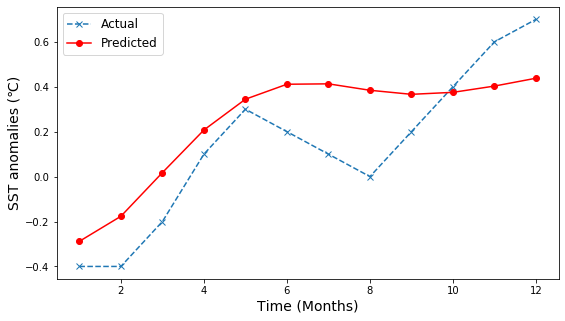

In [11]:
import os
print (round_true_values)
print (predicted_values)

if(os.path.exists('12_months_ConvLSTM_Encoder-Decoder Model_EMD')==False):
    os.makedirs('12_months_ConvLSTM_Encoder-Decoder Model_EMD')

plt.figure(figsize=(9,5))
index_start = np.array(range(1,13))
#plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
plt.plot(index_start,round_true_values.reshape(-1),marker="x",linestyle='--',label='Actual')
plt.plot(index_start,predicted_values.reshape(-1),color="red",marker="o",label='Predicted')

plt.xlabel('Time (Months)',fontsize=14,color="black")
plt.ylabel('SST anomalies (℃)',fontsize=14,color="black")

plt.legend(loc=2,fontsize=12) 

plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_the_final_predicting_and_real_result.png')
plt.show() 
